In [1]:
# Pandas
import pandas as pd
# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight
# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
# Plot
import matplotlib.pyplot as plt
# Utility
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools

In [2]:
# Audio
import librosa
import librosa.display

In [3]:
dataset = []
for folder in ["../dl project/heartbeat_sound/set_a/**","../dl project/heartbeat_sound/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            # skip audio smaller than 4 secs
            if librosa.get_duration(filename=filename)>=4:
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    dataset.append({
                                    "filename": filename,
                                    "label": label
                                  })
                
dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)

C:\Users\91879\AppData\Local\Temp\ipykernel_6860\2182545183.py:7: FutureWarning: get_duration() keyword argument 'filename' has been renamed to 'path' in version 0.10.0.
	This alias will be removed in version 1.0.
  if librosa.get_duration(filename=filename)>=4:


In [4]:
#dataset info
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404 entries, 70 to 102
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  404 non-null    object
 1   label     404 non-null    object
dtypes: object(2)
memory usage: 9.5+ KB


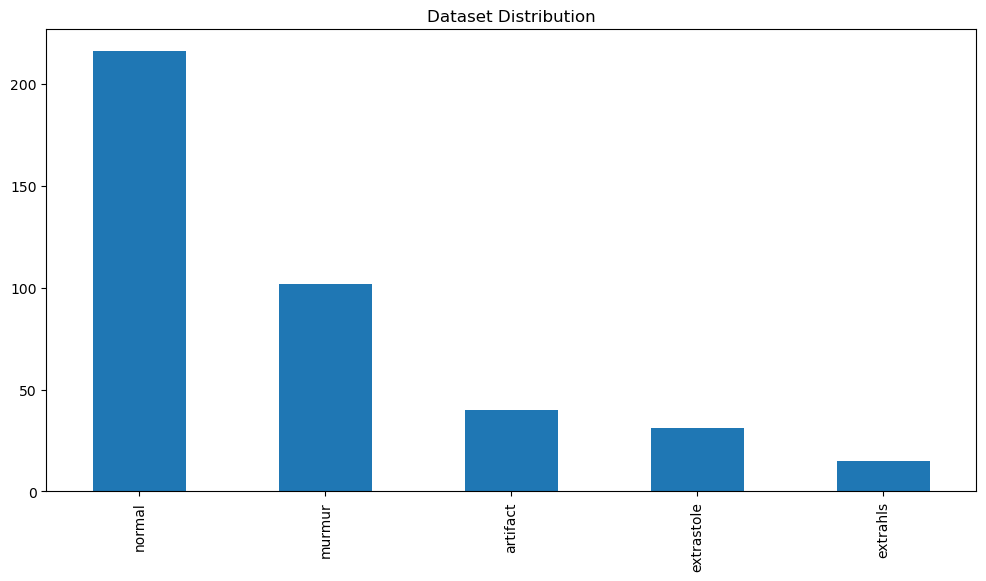

In [5]:
plt.figure(figsize=(12,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset Distribution")
plt.show()

In [6]:
#training and testing dataset split
train, test = train_test_split(dataset, test_size=0.20, random_state=42)
print("Train: %i" % len(train))
print("Test: %i" % len(test))

#show audio info
plt.figure(figsize=(20,20))
idx = 0
for label in dataset.label.unique():
    y, sr = librosa.load(dataset[dataset.label==label].filename.iloc[0], duration=4)
    idx+=1

Train: 323
Test: 81


<Figure size 2000x2000 with 0 Axes>

In [7]:
print(dataset.columns)

Index(['filename', 'label'], dtype='object')


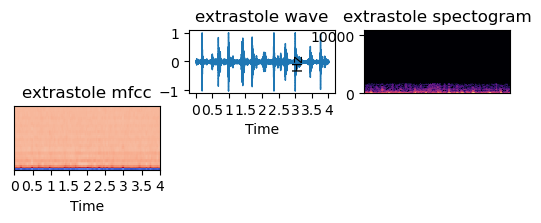

In [8]:
#filter
from scipy.signal import butter, lfilter
from scipy import signal
fs = 22050.0
t = np.arange(900) / fs
signala = np.sin(2*np.pi*900*t)
signalb = np.sin(2*np.pi*30*t)
signalc = signala + signalb
fc = 30  
w = fc / (fs / 2)
b, a = signal.butter(5, w, 'low')
output = signal.filtfilt(b, a, signalc)


#waveplot, mfcc, spectrograms
plt.subplot(5,3, idx)
plt.title("%s wave" % label)
librosa.display.waveshow(y, sr=sr)
idx+=1
plt.subplot(5, 3, idx)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
librosa.display.specshow(D, y_axis='linear')
plt.title("%s spectogram" % label)
idx+=1
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
plt.subplot(5,3, idx)
librosa.display.specshow(mfccs, x_axis='time')
plt.title("%s mfcc" % label)
plt.show()

In [9]:
#feature extraction from audio
def extract_features(audio_path):
    y, sr = librosa.load(audio_path, duration=4)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfccs

x_train, x_test = [], []
print("Extract features from TRAIN and TEST dataset")
for idx in tqdm(range(len(train))):
    x_train.append(extract_features(train.filename.iloc[idx]))
for idx in tqdm(range(len(test))):
    x_test.append(extract_features(test.filename.iloc[idx]))

x_test = np.asarray(x_test)
x_train = np.asarray(x_train)
print("X train:", x_train.shape)
print("X test:", x_test.shape)


Extract features from TRAIN and TEST dataset


100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:02<00:00, 34.65it/s]

X train: (323, 40, 173)
X test: (81, 40, 173)


In [10]:
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

#class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = class_weight.compute_class_weight(class_weight = "balanced", classes= np.unique(y_train), y= y_train)

#input shape
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print("X train:", x_train.shape)
print("Y train:", y_train.shape)
print()
print("X test:", x_test.shape)
print("Y test:", y_test.shape)

X train: (323, 40, 173, 1)
Y train: (323, 5)

X test: (81, 40, 173, 1)
Y test: (81, 5)


In [11]:
#CNN Model
model = Sequential()
model.add(Conv2D(filters=16, 
                 kernel_size=2,
                 input_shape=(x_train.shape[1],
                              x_train.shape[2],
                              x_train.shape[3]),
                 activation='relu'))

model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(GlobalAveragePooling2D())
model.add(Dense(len(encoder.classes_), activation='softmax'))
model.summary()


#Compile model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 172, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 86, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 85, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 42, 32)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 42, 32)         0

In [12]:
class_weights = pd.DataFrame(class_weights)[0].to_dict()
history = model.fit(x_train,
                    y_train,
                    batch_size=128,
                    epochs=500,
                    validation_data=(x_test, y_test),
                    class_weight=class_weights,
                    shuffle=True)

Epoch 1/500
3/3 [==============================] - 4s 644ms/step - loss: 5.4349 - accuracy: 0.2291 - val_loss: 1.6960 - val_accuracy: 0.4444
Epoch 2/500
3/3 [==============================] - 1s 273ms/step - loss: 3.1327 - accuracy: 0.4582 - val_loss: 2.7995 - val_accuracy: 0.0864
Epoch 3/500
3/3 [==============================] - 1s 285ms/step - loss: 2.7818 - accuracy: 0.1424 - val_loss: 2.3886 - val_accuracy: 0.2099
Epoch 4/500
3/3 [==============================] - 1s 205ms/step - loss: 1.9060 - accuracy: 0.2291 - val_loss: 1.7926 - val_accuracy: 0.4074
Epoch 5/500
3/3 [==============================] - 1s 221ms/step - loss: 1.9780 - accuracy: 0.2910 - val_loss: 1.3888 - val_accuracy: 0.4444
Epoch 6/500
3/3 [==============================] - 1s 211ms/step - loss: 1.6322 - accuracy: 0.5077 - val_loss: 1.3186 - val_accuracy: 0.4691
Epoch 7/500
3/3 [==============================] - 1s 210ms/step - loss: 1.6041 - accuracy: 0.3963 - val_loss: 1.4589 - val_accuracy: 0.2222
Epoch 8/500
3

Epoch 59/500
3/3 [==============================] - 1s 216ms/step - loss: 0.6870 - accuracy: 0.5573 - val_loss: 1.3511 - val_accuracy: 0.4691
Epoch 60/500
3/3 [==============================] - 1s 191ms/step - loss: 0.6481 - accuracy: 0.5573 - val_loss: 1.3827 - val_accuracy: 0.4691
Epoch 61/500
3/3 [==============================] - 1s 206ms/step - loss: 0.6983 - accuracy: 0.4985 - val_loss: 1.4144 - val_accuracy: 0.4815
Epoch 62/500
3/3 [==============================] - 1s 199ms/step - loss: 0.6678 - accuracy: 0.5232 - val_loss: 1.4571 - val_accuracy: 0.4815
Epoch 63/500
3/3 [==============================] - 1s 231ms/step - loss: 0.7130 - accuracy: 0.4861 - val_loss: 1.5163 - val_accuracy: 0.4321
Epoch 64/500
3/3 [==============================] - 1s 219ms/step - loss: 0.7226 - accuracy: 0.5418 - val_loss: 1.4263 - val_accuracy: 0.4691
Epoch 65/500
3/3 [==============================] - 1s 200ms/step - loss: 0.6865 - accuracy: 0.5170 - val_loss: 1.4276 - val_accuracy: 0.4444
Epoch 

3/3 [==============================] - 1s 182ms/step - loss: 0.6239 - accuracy: 0.4830 - val_loss: 1.3458 - val_accuracy: 0.4691
Epoch 117/500
3/3 [==============================] - 1s 197ms/step - loss: 0.6149 - accuracy: 0.5294 - val_loss: 1.2810 - val_accuracy: 0.5556
Epoch 118/500
3/3 [==============================] - 1s 195ms/step - loss: 0.6027 - accuracy: 0.6316 - val_loss: 1.3200 - val_accuracy: 0.5309
Epoch 119/500
3/3 [==============================] - 1s 182ms/step - loss: 0.5927 - accuracy: 0.5387 - val_loss: 1.3989 - val_accuracy: 0.4568
Epoch 120/500
3/3 [==============================] - 1s 196ms/step - loss: 0.5906 - accuracy: 0.5108 - val_loss: 1.2891 - val_accuracy: 0.5185
Epoch 121/500
3/3 [==============================] - 1s 201ms/step - loss: 0.5934 - accuracy: 0.6533 - val_loss: 1.2698 - val_accuracy: 0.5309
Epoch 122/500
3/3 [==============================] - 1s 235ms/step - loss: 0.6216 - accuracy: 0.5356 - val_loss: 1.3880 - val_accuracy: 0.4691
Epoch 123/500

3/3 [==============================] - 1s 192ms/step - loss: 0.5465 - accuracy: 0.5635 - val_loss: 1.3980 - val_accuracy: 0.4691
Epoch 174/500
3/3 [==============================] - 1s 219ms/step - loss: 0.5661 - accuracy: 0.6068 - val_loss: 1.3439 - val_accuracy: 0.5309
Epoch 175/500
3/3 [==============================] - 1s 289ms/step - loss: 0.5667 - accuracy: 0.5913 - val_loss: 1.4025 - val_accuracy: 0.4938
Epoch 176/500
3/3 [==============================] - 1s 192ms/step - loss: 0.5544 - accuracy: 0.5046 - val_loss: 1.3937 - val_accuracy: 0.4691
Epoch 177/500
3/3 [==============================] - 1s 212ms/step - loss: 0.5928 - accuracy: 0.5882 - val_loss: 1.3146 - val_accuracy: 0.5802
Epoch 178/500
3/3 [==============================] - 1s 205ms/step - loss: 0.5224 - accuracy: 0.5882 - val_loss: 1.4473 - val_accuracy: 0.4815
Epoch 179/500
3/3 [==============================] - 1s 208ms/step - loss: 0.5890 - accuracy: 0.4706 - val_loss: 1.3568 - val_accuracy: 0.5309
Epoch 180/500

3/3 [==============================] - 1s 299ms/step - loss: 0.5323 - accuracy: 0.5201 - val_loss: 1.3837 - val_accuracy: 0.5309
Epoch 231/500
3/3 [==============================] - 1s 291ms/step - loss: 0.5210 - accuracy: 0.5913 - val_loss: 1.3574 - val_accuracy: 0.5679
Epoch 232/500
3/3 [==============================] - 1s 300ms/step - loss: 0.5190 - accuracy: 0.5882 - val_loss: 1.3694 - val_accuracy: 0.5432
Epoch 233/500
3/3 [==============================] - 1s 295ms/step - loss: 0.5265 - accuracy: 0.6130 - val_loss: 1.4050 - val_accuracy: 0.4938
Epoch 234/500
3/3 [==============================] - 1s 303ms/step - loss: 0.5495 - accuracy: 0.5635 - val_loss: 1.3913 - val_accuracy: 0.4938
Epoch 235/500
3/3 [==============================] - 1s 278ms/step - loss: 0.5042 - accuracy: 0.5851 - val_loss: 1.3486 - val_accuracy: 0.5432
Epoch 236/500
3/3 [==============================] - 1s 297ms/step - loss: 0.5160 - accuracy: 0.5975 - val_loss: 1.3416 - val_accuracy: 0.5556
Epoch 237/500

3/3 [==============================] - 1s 243ms/step - loss: 0.4925 - accuracy: 0.6192 - val_loss: 1.4127 - val_accuracy: 0.5556
Epoch 288/500
3/3 [==============================] - 1s 235ms/step - loss: 0.5203 - accuracy: 0.6037 - val_loss: 1.5186 - val_accuracy: 0.4938
Epoch 289/500
3/3 [==============================] - 1s 253ms/step - loss: 0.4843 - accuracy: 0.5573 - val_loss: 1.5212 - val_accuracy: 0.5309
Epoch 290/500
3/3 [==============================] - 1s 238ms/step - loss: 0.5086 - accuracy: 0.6563 - val_loss: 1.4341 - val_accuracy: 0.5432
Epoch 291/500
3/3 [==============================] - 1s 253ms/step - loss: 0.5132 - accuracy: 0.6285 - val_loss: 1.4750 - val_accuracy: 0.5185
Epoch 292/500
3/3 [==============================] - 1s 247ms/step - loss: 0.4846 - accuracy: 0.5789 - val_loss: 1.4854 - val_accuracy: 0.5062
Epoch 293/500
3/3 [==============================] - 1s 254ms/step - loss: 0.4962 - accuracy: 0.5913 - val_loss: 1.4730 - val_accuracy: 0.5185
Epoch 294/500

3/3 [==============================] - 1s 256ms/step - loss: 0.4656 - accuracy: 0.6625 - val_loss: 1.5537 - val_accuracy: 0.5185
Epoch 345/500
3/3 [==============================] - 1s 227ms/step - loss: 0.4661 - accuracy: 0.5820 - val_loss: 1.5219 - val_accuracy: 0.5309
Epoch 346/500
3/3 [==============================] - 1s 264ms/step - loss: 0.4764 - accuracy: 0.5759 - val_loss: 1.4785 - val_accuracy: 0.5309
Epoch 347/500
3/3 [==============================] - 1s 259ms/step - loss: 0.4755 - accuracy: 0.6842 - val_loss: 1.4742 - val_accuracy: 0.6173
Epoch 348/500
3/3 [==============================] - 1s 250ms/step - loss: 0.4725 - accuracy: 0.6873 - val_loss: 1.5928 - val_accuracy: 0.5185
Epoch 349/500
3/3 [==============================] - 1s 254ms/step - loss: 0.4491 - accuracy: 0.6099 - val_loss: 1.6227 - val_accuracy: 0.5062
Epoch 350/500
3/3 [==============================] - 1s 242ms/step - loss: 0.4615 - accuracy: 0.5975 - val_loss: 1.4624 - val_accuracy: 0.6420
Epoch 351/500

3/3 [==============================] - 1s 199ms/step - loss: 0.4502 - accuracy: 0.6533 - val_loss: 1.5804 - val_accuracy: 0.6173
Epoch 402/500
3/3 [==============================] - 1s 205ms/step - loss: 0.4392 - accuracy: 0.6471 - val_loss: 1.5521 - val_accuracy: 0.5802
Epoch 403/500
3/3 [==============================] - 1s 211ms/step - loss: 0.4654 - accuracy: 0.6285 - val_loss: 1.4995 - val_accuracy: 0.6296
Epoch 404/500
3/3 [==============================] - 1s 226ms/step - loss: 0.4502 - accuracy: 0.6656 - val_loss: 1.6066 - val_accuracy: 0.5679
Epoch 405/500
3/3 [==============================] - 1s 224ms/step - loss: 0.4257 - accuracy: 0.6192 - val_loss: 1.5113 - val_accuracy: 0.6173
Epoch 406/500
3/3 [==============================] - 1s 294ms/step - loss: 0.4514 - accuracy: 0.7214 - val_loss: 1.4927 - val_accuracy: 0.6420
Epoch 407/500
3/3 [==============================] - 1s 317ms/step - loss: 0.4151 - accuracy: 0.6502 - val_loss: 1.6801 - val_accuracy: 0.5185
Epoch 408/500

3/3 [==============================] - 1s 332ms/step - loss: 0.4531 - accuracy: 0.6006 - val_loss: 1.6340 - val_accuracy: 0.5679
Epoch 459/500
3/3 [==============================] - 1s 317ms/step - loss: 0.4065 - accuracy: 0.6409 - val_loss: 1.5268 - val_accuracy: 0.6420
Epoch 460/500
3/3 [==============================] - 1s 273ms/step - loss: 0.3914 - accuracy: 0.7028 - val_loss: 1.5003 - val_accuracy: 0.6420
Epoch 461/500
3/3 [==============================] - 1s 297ms/step - loss: 0.4116 - accuracy: 0.6811 - val_loss: 1.5402 - val_accuracy: 0.6420
Epoch 462/500
3/3 [==============================] - 1s 297ms/step - loss: 0.4129 - accuracy: 0.6625 - val_loss: 1.6209 - val_accuracy: 0.6173
Epoch 463/500
3/3 [==============================] - 1s 262ms/step - loss: 0.4153 - accuracy: 0.7028 - val_loss: 1.5894 - val_accuracy: 0.6296
Epoch 464/500
3/3 [==============================] - 1s 256ms/step - loss: 0.4144 - accuracy: 0.6935 - val_loss: 1.5906 - val_accuracy: 0.6296
Epoch 465/500

Text(0.5, 1.0, 'Loss Curve')

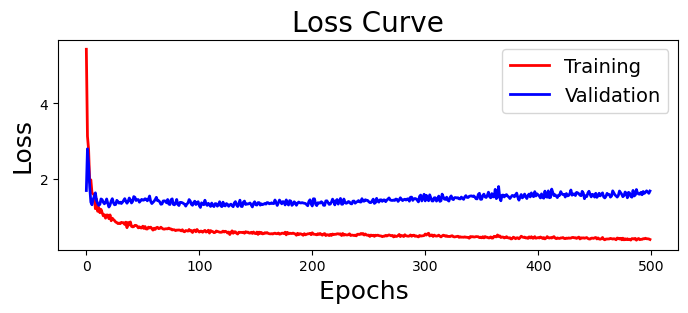

In [13]:
# Loss Curve
plt.figure(figsize=[8,6])
plt.subplot(211)
plt.plot(history.history['loss'],'r',linewidth=2.0)
plt.plot(history.history['val_loss'],'b',linewidth=2.0)
plt.legend(['Training', 'Validation'], fontsize=14)
plt.xlabel('Epochs ',fontsize=18)
plt.rc('xtick', labelsize=13)
plt.ylabel('Loss',fontsize=18)
plt.rc('ytick', labelsize=13)
plt.title('Loss Curve',fontsize=20)

Text(0.5, 1.0, 'Accuracy Curve')

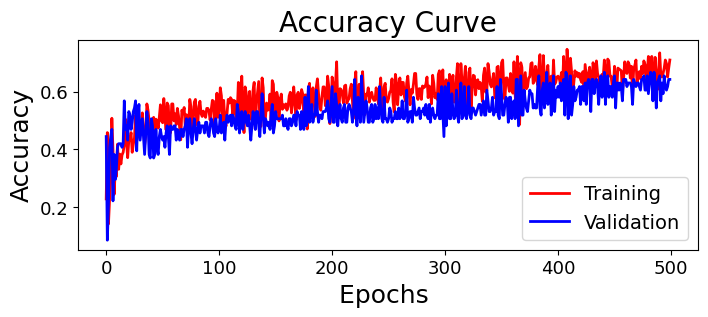

In [14]:
# Accuracy Curve
plt.figure(figsize=[8,6])
plt.subplot(212)
plt.plot(history.history['accuracy'],'r',linewidth=2.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=2.0)
plt.legend(['Training', 'Validation'],fontsize=14)
plt.xlabel('Epochs ',fontsize=18)
plt.rc('xtick', labelsize=13)
plt.ylabel('Accuracy',fontsize=18)
plt.rc('ytick', labelsize=13)
plt.title('Accuracy Curve', fontsize=20)

In [15]:
# Save model and weights
model_name = "heartbeat_disease.h5"
model.save(model_name)
print('Saved trained model at %s ' % model_name)

Saved trained model at heartbeat_disease.h5 


In [16]:
#model evaluation
scores = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

3/3 [==============================] - 0s 18ms/step - loss: 1.6825 - accuracy: 0.6420
Test loss: 1.6824817657470703
Test accuracy: 0.6419752836227417


In [17]:
#value prediction and classification report
predictions = model.predict(x_test, verbose=1)
y_true, y_pred = [],[]
classes = encoder.classes_
for idx, prediction in enumerate(predictions):
    y_true.append(classes[np.argmax(y_test[idx])])
    y_pred.append(classes[np.argmax(prediction)])
print(classification_report(y_pred, y_true))

3/3 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

    artifact       0.78      0.78      0.78         9
    extrahls       1.00      0.40      0.57        10
  extrastole       0.83      0.42      0.56        12
      murmur       0.71      0.61      0.65        28
      normal       0.50      0.86      0.63        22

    accuracy                           0.64        81
   macro avg       0.76      0.61      0.64        81
weighted avg       0.71      0.64      0.64        81



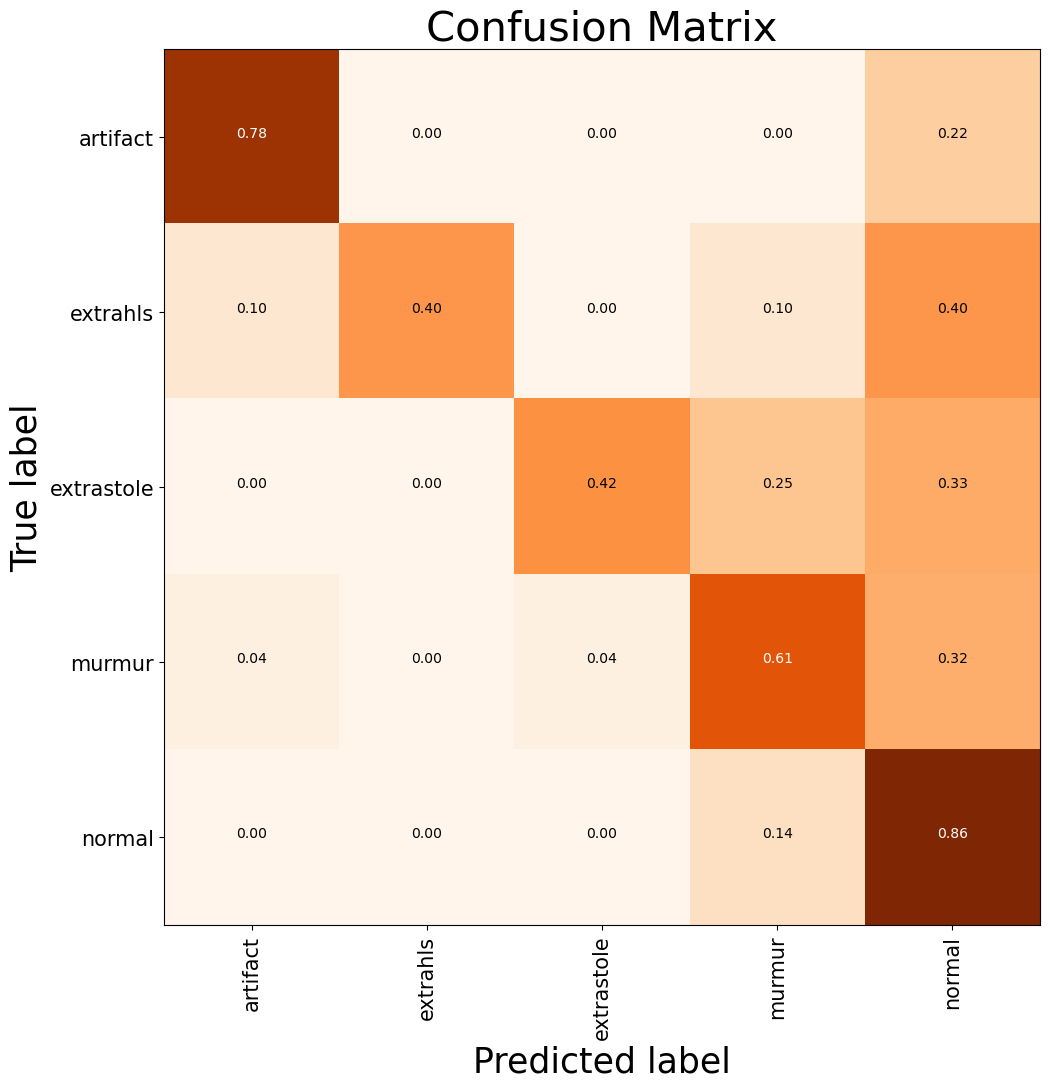

In [18]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    plt.figure(figsize=(11, 11))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.tight_layout()
    plt.show()

cnf_matrix = confusion_matrix(y_pred, y_true)
cnf_matrix = cnf_matrix.astype(float) / cnf_matrix.sum(axis=1)[:, np.newaxis]
plot_confusion_matrix(cnf_matrix, classes, 'Confusion Matrix')